In [373]:
using LowLevelFEM
import LowLevelFEM as FEM

gmsh.initialize()

In [374]:
using SparseArrays, LinearAlgebra

In [375]:
gmsh.open("body2.geo")

Info    : Reading 'body2.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.00394336s, CPU 0.001131s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Transfinite)
Info    : [ 40%] Meshing surface 3 (Transfinite)
Info    : [ 60%] Meshing surface 4 (Transfinite)
Info    : [ 70%] Meshing surface 5 (Transfinite)
Info    : [ 90%] Meshing surface 6 (Transfinite)
Info    : Done meshing 2D (Wall 0.000525992s, CPU 0.000524s)
Info    : Meshing 3D.

In [376]:
mat = FEM.material("body", E=260, ν=0.3, type=:StVenantKirchhoff)
hooke = FEM.Problem([mat], type=:Solid)
stvenkir = FEM.Problem([mat], type=:Solid)
neohooke = FEM.Problem([mat], type=:Solid)

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 61)
Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 61)
Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 61)


LowLevelFEM.Problem("body2", :Solid, 3, 3, LowLevelFEM.Material[LowLevelFEM.Material("body", :StVenantKirchhoff, 260.0, 0.3, 7.85e-9, 45.0, 4.2e8, 1.2e-5, 150.0, 100.0, 216.66666666666666)], 1.0, 525)

In [377]:
supp = FEM.displacementConstraint("left", ux=0, uy=0, uz=0)
suppL = FEM.displacementConstraint("left", ux=0)
suppB = FEM.displacementConstraint("bottom", uy=0)
suppF = FEM.displacementConstraint("front", uz=0)
traction = FEM.load("right", fy=-0.08 * 0.57 * 0.8 * 0.95)
#bodyforce = FEM.load("body", fx=1)

problem = hooke
q = FEM.solveDisplacement(problem, [traction], [supp])
S = FEM.solveStress(problem, q)

LowLevelFEM.TensorField([[-1.055018034048144; -0.3512667176812846; … ; 0.0707955318559422; 0.190483364698033;;], [-0.7755601037538373; -0.34937635543813383; … ; 0.050739265212312305; 0.04491424122807444;;], [-0.7441802137718759; -0.3428776441166743; … ; 0.04956730037930478; 0.06155340577863749;;], [-0.6981468944224277; -0.322167916382024; … ; 0.045842628916217536; 0.04848415922179655;;], [-0.656147314541736; -0.3039053228228644; … ; 0.04326680649374293; 0.04612008685962754;;], [-0.6129212511732651; -0.28609227234143997; … ; 0.04033631062703017; 0.042063286493362134;;], [-0.5700217085043116; -0.2679262782139008; … ; 0.03745614064414439; 0.038097574968447484;;], [-0.5270258211569353; -0.24986472226521117; … ; 0.034575980691194; 0.03411463869433903;;], [-0.4840561255238226; -0.23178187182389398; … ; 0.03169432921667835; 0.030144936315870577;;], [-0.441080600153008; -0.21370275676303452; … ; 0.028813112886232083; 0.026171146833947348;;]  …  [0.9157873914112376; -0.19673823136497348; … ; 0.

In [378]:
u1 = FEM.showDoFResults(problem, q, :uvec)
S1 = FEM.showElementResults(problem, S, :s)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


1

In [379]:
problem = stvenkir
problem = neohooke

LowLevelFEM.Problem("body2", :Solid, 3, 3, LowLevelFEM.Material[LowLevelFEM.Material("body", :StVenantKirchhoff, 260.0, 0.3, 7.85e-9, 45.0, 4.2e8, 1.2e-5, 150.0, 100.0, 216.66666666666666)], 1.0, 525)

In [380]:
followerLoad = false
loadSteps = 100
rampedLoad = true
rampedSupport = false
maxIteration = 10
saveSteps = true
saveIterations = false
plotConvergence = true
ε = 1e-5

r0 = FEM.nodePositionVector(problem)
err0 = abs(maximum(r0.a) - minimum(r0.a))
f = FEM.loadVector(problem, [traction])
r = []
r1 = []
push!(r, r0.a)
r0 = copy(r0)
e = []

for j in range(1, loadSteps)
    fact = rampedLoad == true ? j / loadSteps : 1
    if rampedSupport == true
        FEM.applyDeformationBoundaryConditions!(problem, r0, [supp], fact=1 / loadSteps)
    elseif rampedSupport == false && j == 1
        FEM.applyDeformationBoundaryConditions!(problem, r0, [supp])
    end
    err = 1
    i = 0
    while err > ε && i < maxIteration
        i += 1

        Kl = FEM.tangentMatrixConstitutive(problem, r0)
        Knl = FEM.tangentMatrixInitialStress(problem, r0)
        if followerLoad == false
            f = FEM.nonFollowerLoadVector(problem, r0, [traction])
        end
        fnl = FEM.equivalentNodalForce(problem, r0)
        K1, f1 = FEM.suppressDeformationAtBoundaries(problem, Kl + Knl, fact * f - fnl, [supp])
        q = FEM.solveDisplacement(K1, f1)
        r0 += q
        if saveIterations == true
            push!(r, r0.a)
            r0 = copy(r0)
        end
        err = maximum(abs.(q.a)) / err0
        if plotConvergence == true
            append!(e, err)
        end
    end
    if saveSteps == true
        push!(r, r0.a)
        r0 = copy(r0)
    end
end
if saveIterations == true || saveSteps == true
    n = length(r)
    r1 = zeros(length(r0.a), n)
    for i in 1:n
        r1[:, i] = r[i]
    end
else
    r1 = zeros(length(r0.a), 1)
    r1 = r0
end

In [381]:
r1 = FEM.VectorField([], r1, 1:size(r1, 2), [], size(r1, 2), :u3D)

LowLevelFEM.VectorField(Matrix{Float64}[], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.7499999999999999 0.7453988689187545 … 2.246733695781694 0.7430534870507103; 0.75 0.7499998554495974 … 1.2223236743150716 0.3560932834762963], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0], Int64[], 101, :u3D)

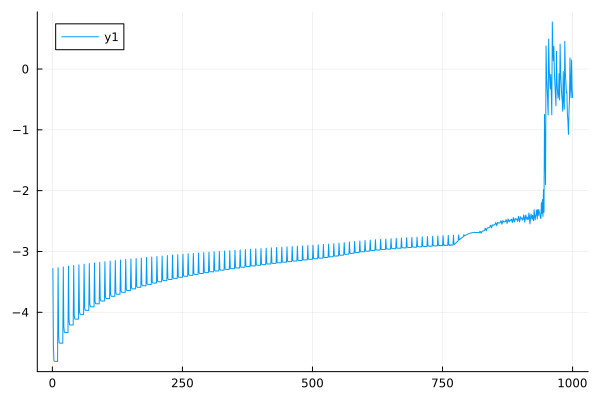

In [382]:
using Plots
plot(log10.(e))

In [383]:
u1 = copy(r1)
r0 = FEM.nodePositionVector(problem)
for i in 1:size(r1.a, 2)
    u1.a[:, i] = r1.a[:, i] - r0.a
end

u2 = FEM.showDoFResults(problem, u1, :uvec, visible=true)

2

In [384]:
phtag = FEM.getTagForPhysicalName("A")
pttag = gmsh.model.getEntitiesForPhysicalGroup(0, 31)[1]
coord = gmsh.model.getValue(0, pttag, [])
R1 = FEM.nodePositionVector(neohooke)
FEM.probe(R1, coord[1], coord[2], coord[3])

3-element Vector{Float64}:
 5.0
 0.29999999999999993
 0.3

In [385]:
#FEM.plotOnPath(problem, "horizontal", u2)
#FEM.plotOnPath(problem, "vertical", u2)

In [386]:
r = FEM.nodePositionVector(problem)
ux(x, y, z) = 0.4x
uy(x, y, z) = 0.5y
uz(x, y, z) = 0.6z
q0 = FEM.field("body", fx=ux, fy=uy, fz=uz)
q = FEM.vectorField(problem, [q0])
F = FEM.deformationGradient(problem, q)

LowLevelFEM.TensorField([[0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;]  …  [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; … ; 0.0; 0.6000000000000001;;], [0.39999999999999947; 0.0; …

In [387]:
reshape(F.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 0.4  0.0  0.0
 0.0  0.5  0.0
 0.0  0.0  0.6

In [388]:
E = (F' * F - FEM.unitTensor(F)) / 2

reshape(E.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -0.42   0.0     0.0
  0.0   -0.375   0.0
  0.0    0.0    -0.32

In [389]:
e = (FEM.unitTensor(F) - inv(F * F')) / 2

reshape(e.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -2.625   0.0   0.0
  0.0    -1.5   0.0
  0.0     0.0  -0.888889

In [390]:
e = inv(F') * E * inv(F)

reshape(e.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -2.625   0.0   0.0
  0.0    -1.5   0.0
  0.0     0.0  -0.888889

In [391]:
U = sqrt(F' * F)

reshape(U.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 0.4  0.0  0.0
 0.0  0.5  0.0
 0.0  0.0  0.6

In [392]:
Ex = 10
νxy = 0.3
λ = Ex * νxy / ((1 + νxy) * (1 - 2νxy))
μ = Ex / (2 * (1 + νxy))
I3 = FEM.unitTensor(F)
iC = inv(F' * F)
J1 = det(F)
SII = μ * (I3 - iC) + λ * log(J1) / J1 * I3

reshape(SII.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -122.128     0.0       0.0
    0.0    -113.474     0.0
    0.0       0.0    -108.773

In [393]:
function probe(A, x, y, z)
    elementTag, elementType, nodeTags, u, v, w = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, false)
    elementName, dim, order, numNodes::Int64, localNodeCoord, numPrimaryNodes = gmsh.model.mesh.getElementProperties(elementType)
    comp, fun, ori = gmsh.model.mesh.getBasisFunctions(elementType, [u, v, w], "Lagrange")
    SS = [0.0, 0, 0, 0, 0, 0, 0, 0, 0]
    if isa(A, FEM.TensorField)
        ind = findfirst(i -> i == elementTag, SII.numElem)
        for i in range(1, 9)
            SS[i] = fun' * SII.A[ind][i:9:9numNodes, 1]
        end
    elseif isa(A, Matrix)
        for i in range(1, 9)
            SS[i] = fun' * A[9nodeTags.-(9-i), 1]
        end
    end
    return reshape(SS, 3, 3)
end

probe (generic function with 1 method)

In [394]:
SII2 = FEM.elementsToNodes(problem, SII)

LowLevelFEM.TensorField(Matrix{Float64}[], [-122.12805462500454; 0.0; … ; -4.2700885562489974e-16; -108.77335377030371;;], [0.0], Int64[], 1, :e)

In [395]:
probe(SII2, 0, 0, 0)

3×3 Matrix{Float64}:
 -122.128           8.7422e-27      5.04108e-15
    8.7422e-27   -113.474          -4.55476e-15
    5.04108e-15    -4.55476e-15  -108.773

In [396]:
field = FEM.field("body", f=2)
sc = FEM.ScalarField(problem, [field])

LowLevelFEM.ScalarField([[2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]  …  [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), Float64[], [473, 474, 475, 476, 477, 478, 479, 480, 481, 482  …  783, 784, 785, 786, 787, 788, 789, 790, 791, 792], 1, :scalarInElements)

In [397]:
I3 = FEM.unitTensor(F)
J = det(F)

LowLevelFEM.ScalarField([[0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;], [0.11999999999999986; 0.11999999999999993; … ; 0.11999999999999986; 0.11999999999999986;;]  …  [0.11999999999999986; 0.11999999999999993; … ; 0.119

In [398]:
sc * I3

LowLevelFEM.TensorField([[2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]  …  [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), [0.0], [473, 474, 475, 476, 477, 478, 479, 480, 481, 482  …  783, 784, 785, 786, 787, 788, 789, 790, 791, 792], 1, :e)

In [399]:
I3 - I3

LowLevelFEM.TensorField([[0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;]  …  [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;]], Matrix{Float64}(undef, 0, 0), [0.0], [473, 474, 475, 476, 477, 478, 479, 480, 481, 482  …  783, 784, 785, 786, 787, 788, 789, 790, 791, 792], 1, :e)

In [400]:
σ = F * SII * F' / det(F)

reshape(σ.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -162.837     0.0       0.0
    0.0    -236.405     0.0
    0.0       0.0    -326.32

In [401]:
J = 0.5 * 0.5 * 0.5
μ / J * (J^(2 / 3) - 1) + λ / J * log(J)

-119.05114807753088

In [402]:
FEM.openPostProcessor()

-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.7.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


XRequest.18: BadValue 0x0


In [403]:
gmsh.finalize()